# Carregando dataset

In [1]:
import os
import numpy as np
import pydicom
from tqdm import tqdm # Ver processo do loop
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import pickle
from keras.preprocessing.image import ImageDataGenerator
import random
from keras import backend as K
from sklearn.model_selection import train_test_split
from skimage import exposure
import shutil

seed = 42
np.random.seed(seed)
random.seed(seed)

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

DATASET_PATH = 'Sunnybrook_Dataset/SCD_DeidentifiedImages/'
CONTOUR_PATH = 'Sunnybrook_Dataset/SCD_ManualContours/'
# PICKLE_PATH = 'Sunnybrook_Dataset/pickled_data/'
PICKLE_PATH = 'pickle/'
AUGMENTATION_PATH = 'Sunnybrook_Dataset/Data_Augmentation/'
MODEL_PATH = 'modelo/Unet_da'

In [2]:
def converter_pixel_array_rgb(dicom):
    dicom_rgb = np.empty((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=dicom.dtype)
    dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]
    dicom_rgb = dicom_rgb / np.max(dicom_rgb)
    return dicom_rgb

def pre_processamento(img):
#     img_cs = exposure.equalize_adapthist(img, clip_limit=0.03)
    p2, p98 = np.percentile(img, (2,98))
    img_cs = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_cs

def converter_mascara_binario(mask):
    im_bw = mask[:,:,0]
    im_bw = im_bw[:,:,np.newaxis]
    return im_bw

In [3]:
###### ATUALIZAR BASE DA DADOS APOS DATA AUGMENTATION
def atualiza_bd(conjunto, path, tipo_conjunto):
    AUG_PATH = path + '/'
#     AUG_PATH = AUGMENTATION_PATH + tipo_conjunto + '_mask' if mascara else AUGMENTATION_PATH + tipo_conjunto
#     AUG_PATH += '/'
    
    novo_conjunto = np.empty((2*len(conjunto), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    
    cnt = 0
    print("Adicionando imagens que pertencem a base ", tipo_conjunto)
    for image in conjunto:
        novo_conjunto[cnt] = image
        cnt += 1
        
    print("Adicionando imagens do data augmentation a base ", tipo_conjunto)
    for files in os.listdir(AUG_PATH):
        arquivo = plt.imread(AUG_PATH + files)
        arquivo = converter_pixel_array_rgb(arquivo)
        novo_conjunto[cnt] = arquivo
        cnt += 1
    
    return novo_conjunto

In [4]:
###### DATA AUGMENTATION
def data_augmentation(conjunto, mascara, tipo_conjunto):
    AUG_PATH = AUGMENTATION_PATH + tipo_conjunto
    AUG_MASK_PATH = AUGMENTATION_PATH + tipo_conjunto + '_mask'
    
    shutil.rmtree(AUG_PATH)
    shutil.rmtree(AUG_MASK_PATH)
    os.mkdir(AUG_PATH)
    os.mkdir(AUG_MASK_PATH)
    
    datagen = ImageDataGenerator(rotation_range=180,
                                 zoom_range=0.5,
                                 horizontal_flip=True,
                                 vertical_flip=True
                                )
    
    print("Criando novas imagens")
    cnt_data_aug = 0
    for batch in datagen.flow(conjunto, batch_size = 1, shuffle = False, seed = seed,
                              save_to_dir = AUG_PATH, save_prefix = 'da', save_format = 'jpeg'):
        cnt_data_aug += 1
        if cnt_data_aug == len(conjunto):
            break
            
    print("Criando novos ground-truth")
    cnt_data_aug = 0
    for batch in datagen.flow(mascara, batch_size = 1, shuffle = False, seed = seed,
                              save_to_dir = AUG_MASK_PATH, save_prefix = 'da', save_format = 'jpeg'):
        cnt_data_aug += 1
        if cnt_data_aug == len(mascara):
            break
    
    conjunto = atualiza_bd(conjunto, AUG_PATH, tipo_conjunto)
    mascara = atualiza_bd(mascara, AUG_MASK_PATH, tipo_conjunto)
    
    return conjunto, mascara

In [5]:
##### contorno_pickle = array com as coordenadas do contorno
##### mascara_pickle = mascara do ground-truth
##### scans_pickle = np.array(dicom.pixel_array)

######################################################################

scans_file = PICKLE_PATH + 'scans_pickle.pickle'
contours_file = PICKLE_PATH + 'contorno_pickle.pickle'
masks_file = PICKLE_PATH + 'mascara_pickle.pickle'
with open(scans_file, 'rb') as f:
    all_scans = pickle.load(f)
    
with open(contours_file, 'rb') as f:
    all_contours = pickle.load(f)
    
with open(masks_file, 'rb') as f:
    all_masks = pickle.load(f)

# all_scans = list(map(pre_processamento, all_scans))
all_scans = list(map(converter_pixel_array_rgb, all_scans))
all_scans = np.array(all_scans)

all_masks = list(map(converter_mascara_binario, all_masks))
all_masks = np.array(all_masks)

# Separar em treino, teste e validacao
X_train, X_test, Y_train, Y_test = train_test_split(all_scans, all_masks, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=1)

Y_train = np.where(Y_train>128, 1.0, 0.0)
Y_val = np.where(Y_val>128, 1.0, 0.0)
Y_test = np.where(Y_test>128, 1.0, 0.0)

print("Total de imagens: ", len(X_train) + len(X_test) + len(X_val))
# Fazer Data augmentation
X_train, Y_train = data_augmentation(X_train, Y_train, 'train')
X_val, Y_val = data_augmentation(X_val, Y_val, 'val')

Total de imagens:  805
Criando novas imagens
Criando novos ground-truth
Adicionando imagens que pertencem a base  train
Adicionando imagens do data augmentation a base  train
Adicionando imagens que pertencem a base  train
Adicionando imagens do data augmentation a base  train
Criando novas imagens
Criando novos ground-truth
Adicionando imagens que pertencem a base  val
Adicionando imagens do data augmentation a base  val
Adicionando imagens que pertencem a base  val
Adicionando imagens do data augmentation a base  val


In [6]:
len(X_train), len(X_test), len(X_val), len(X_train) + len(X_test) + len(X_val)

(1126, 161, 162, 1449)

In [7]:
Y_train.shape

(1126, 256, 256, 1)

In [8]:
len(X_train)

1126

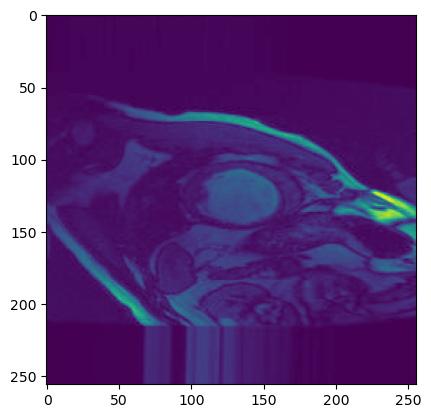

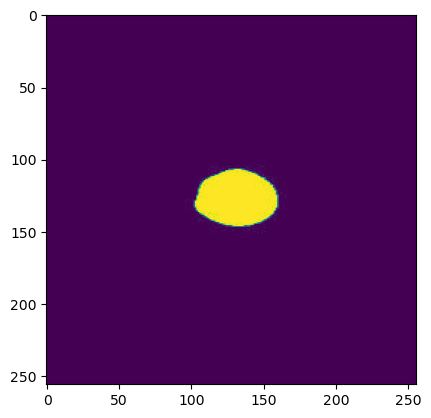

In [9]:
# print(Y_train[0][0])
idx = 805
plt.imshow(X_train[idx])
plt.show()
plt.imshow(Y_train[idx])
plt.show()
# dicom2 = marcar_ground_truth(idx, X_train, Y_train)
# plt.imshow(dicom2)
# plt.show()

In [10]:
kwargs = dict(
        rotation_range=180,
        zoom_range=0.5,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )

X_datagen = ImageDataGenerator(**kwargs)
Y_datagen = ImageDataGenerator(**kwargs)
val_X_datagen = ImageDataGenerator(**kwargs)
val_Y_datagen = ImageDataGenerator(**kwargs)


X_generator = X_datagen.flow(X_train, shuffle=False,
                                    batch_size=10, seed=seed)
Y_generator = Y_datagen.flow(Y_train, shuffle=False,
                                batch_size=10, seed=seed)
train_generator = zip(X_generator, Y_generator)

val_X_generator = val_X_datagen.flow(X_val, shuffle=False,
                                    batch_size=10, seed=seed)
val_Y_generator = val_Y_datagen.flow(Y_val, shuffle=False,
                                batch_size=10, seed=seed)
val_generator = zip(val_X_generator, val_Y_generator)

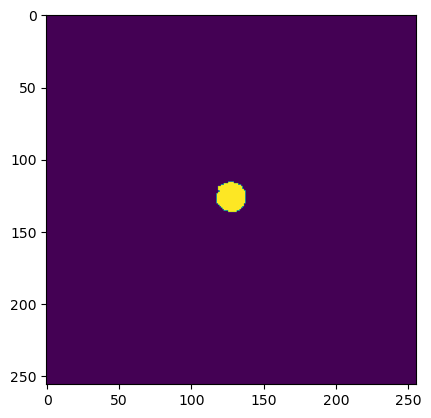

In [11]:
plt.imshow(Y_train[500])
plt.show()

# Metricas

In [12]:
def dice_coef(y_true, y_pred, smooth=1.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2.0 * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(smooth):
    def dice(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
    return dice

def dice_mon(smooth):
    def dicemon(y_true, y_pred):
        return dice_coef(y_true, y_pred, smooth=smooth)
    return dicemon

def jaccard_coef(y_true, y_pred, smooth=0.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    jaccard = K.mean((intersection + smooth) / (union + smooth), axis = 0)
    return jaccard

def jaccard_mon(smooth):
    def jaccardmon(y_true, y_pred):
        return jaccard_coef(y_true, y_pred, smooth=smooth)
    return jaccardmon

# Modelando Unet

In [13]:
import tensorflow as tf
from keras.models import *
from keras.layers import *

tf.random.set_seed(seed)

In [14]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(1, 1, activation='sigmoid')(c9)
 
model = Model(inputs=[inputs], outputs=[outputs])

# Configurando as metricas
smooth = K.epsilon()
dice_model = dice_loss(smooth)
dicemon = dice_mon(smooth)
jaccardmon = jaccard_mon(smooth)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])
# model.compile(optimizer = 'adam', loss = dice_model, metrics = [dicemon, 'accuracy', jaccardmon])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       dropout[0][0]                    
______________________________________________________________________________________________

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH + '.h5', verbose=1, save_weights_only=True)

callbacks = [checkpoint,
#         tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_dicemon'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]



In [16]:
results = model.fit(train_generator,steps_per_epoch=len(X_train)/10,epochs=100,callbacks=callbacks, validation_data=val_generator, validation_steps=len(X_val)/10)
json_model = model.to_json()
open(MODEL_PATH + '.json', 'w').write(json_model)
model.save_weights(MODEL_PATH + '.h5', overwrite=True)

# save:
f = open(MODEL_PATH + '.pckl', 'wb')
pickle.dump(results.history, f)
f.close()

Epoch 1/100
112/112 [==============================] - 91s 579ms/step - loss: 0.8208 - accuracy: 0.9698 - dicemon: 0.0305 - jaccardmon: 0.0158 - val_loss: 0.0892 - val_accuracy: 0.9663 - val_dicemon: 0.1074 - val_jaccardmon: 0.0580

Epoch 00001: saving model to modelo\Unet_da.h5
Epoch 2/100
112/112 [==============================] - 55s 493ms/step - loss: 0.0761 - accuracy: 0.9759 - dicemon: 0.0753 - jaccardmon: 0.0397 - val_loss: 0.0926 - val_accuracy: 0.9668 - val_dicemon: 0.1159 - val_jaccardmon: 0.0628

Epoch 00002: saving model to modelo\Unet_da.h5
Epoch 3/100
112/112 [==============================] - 56s 494ms/step - loss: 0.0772 - accuracy: 0.9748 - dicemon: 0.0843 - jaccardmon: 0.0447 - val_loss: 0.0890 - val_accuracy: 0.9679 - val_dicemon: 0.1169 - val_jaccardmon: 0.0634

Epoch 00003: saving model to modelo\Unet_da.h5
Epoch 4/100
112/112 [==============================] - 56s 494ms/step - loss: 0.0754 - accuracy: 0.9748 - dicemon: 0.0865 - jaccardmon: 0.0460 - val_loss: 0.089

112/112 [==============================] - 57s 506ms/step - loss: 0.0098 - accuracy: 0.9920 - dicemon: 0.8001 - jaccardmon: 0.6951 - val_loss: 0.0149 - val_accuracy: 0.9831 - val_dicemon: 0.7534 - val_jaccardmon: 0.6304

Epoch 00059: saving model to modelo\Unet_da.h5
Epoch 60/100
112/112 [==============================] - 57s 506ms/step - loss: 0.0103 - accuracy: 0.9917 - dicemon: 0.7967 - jaccardmon: 0.6858 - val_loss: 0.0113 - val_accuracy: 0.9840 - val_dicemon: 0.7973 - val_jaccardmon: 0.6911

Epoch 00060: saving model to modelo\Unet_da.h5
Epoch 61/100
112/112 [==============================] - 57s 506ms/step - loss: 0.0098 - accuracy: 0.9919 - dicemon: 0.8072 - jaccardmon: 0.7009 - val_loss: 0.0129 - val_accuracy: 0.9848 - val_dicemon: 0.7651 - val_jaccardmon: 0.6479

Epoch 00061: saving model to modelo\Unet_da.h5
Epoch 62/100
112/112 [==============================] - 57s 509ms/step - loss: 0.0093 - accuracy: 0.9922 - dicemon: 0.8023 - jaccardmon: 0.6952 - val_loss: 0.0174 - val_a

FileNotFoundError: [Errno 2] No such file or directory: 'historymodelo/Unet_da.pckl'

In [17]:
# Carregar modelo
model = model_from_json(open(MODEL_PATH + '.json').read())
model.load_weights(MODEL_PATH + '.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])

# retrieve:    
f = open(MODEL_PATH + '.pckl', 'rb')
results = pickle.load(f)
f.close()

In [19]:
print(results.keys())
model.evaluate(X_train, Y_train)

dict_keys(['loss', 'accuracy', 'dicemon', 'jaccardmon', 'val_loss', 'val_accuracy', 'val_dicemon', 'val_jaccardmon'])
36/36 [==============================] - 52s 459ms/step - loss: 0.0059 - accuracy: 0.9962 - dicemon: 0.8413 - jaccardmon: 0.7415


[0.006618877872824669,
 0.9932445883750916,
 0.8359416723251343,
 0.7341143488883972]

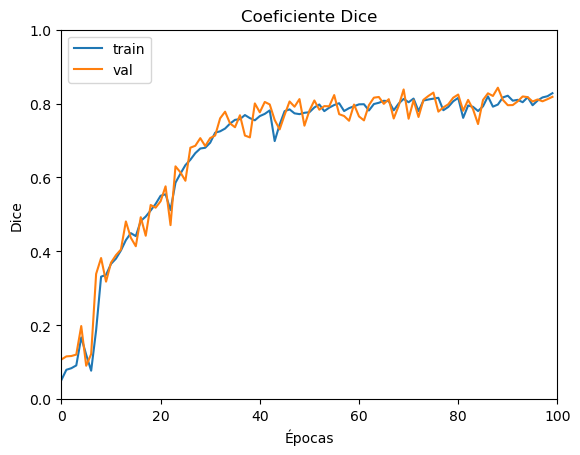

In [20]:
plt.plot(results['dicemon'])
plt.plot(results['val_dicemon'])
plt.title('Coeficiente Dice')

plt.ylabel('Dice')
plt.xlabel('Épocas')
plt.axis([0, 100, 0, 1])
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('dice_unet_da')
plt.show()

In [19]:
predict_test = model.predict(X_test, verbose=1)

6/6 [==============================] - 7s 599ms/step


indice =  28


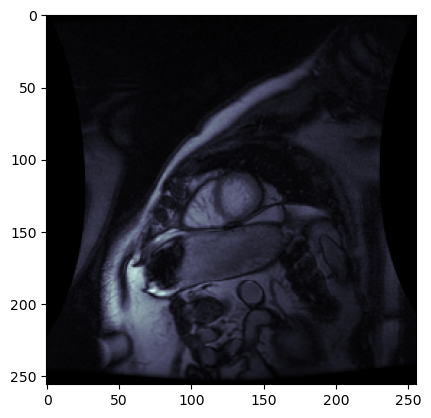

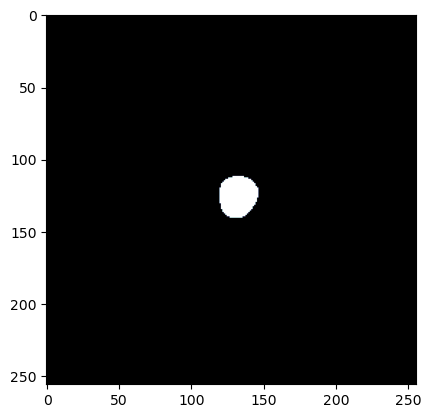

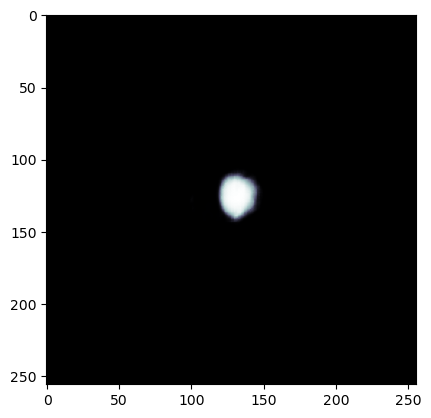

In [20]:
# Ver exemplos de imagens
exemplo = random.randint(0, 160)
print("indice = ", exemplo)

plt.imshow(X_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(predict_test[exemplo], cmap=plt.cm.bone)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


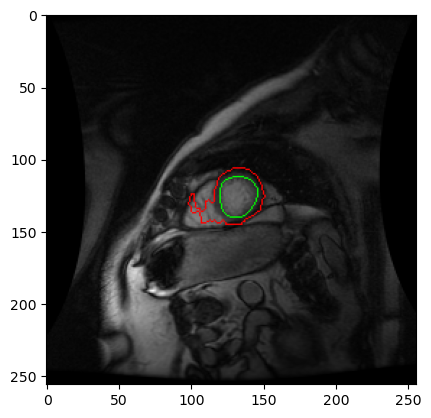

In [21]:
from skimage import img_as_ubyte 

def add_mascara(imagem, mascara, cor):
    img = imagem.copy()
    if np.ndim(img) == 2:
        img2 = np.empty((256, 256, 3), dtype=img.dtype)
        img2[:,:,:] = img[:,:, np.newaxis]
        img = img2
    
    mask = mascara.copy()
    if np.ndim(mask) == 3:
#         mask = cv2.cvtColor(mask.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
#         ret, bw_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        bw_mask = img_as_ubyte(mask)
    else:
        bw_mask = img_as_ubyte(mask)
        
    contours, _ = cv2.findContours(bw_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        ctrs = [len(ctr) for ctr in contours]
        max_ctr = np.argmax(ctrs)
        pontos = np.array([pt[0] for pt in contours[max_ctr]])
        cv2.drawContours(img, np.array([pontos]),  0, cor, 1)

    return img
    

def marcar_ground_truth(ind, imagem, mascara):
    img1 = imagem[ind]
    img1 = np.squeeze(img1)
    img2 = mascara[ind]   
    img3 = add_mascara(img1, img2, (0, 255, 0))
    
    return img3

def marcar_predict(ind, imagem, mascara):
    img1 = imagem
    img2 = np.squeeze(mascara[ind])
    img3 = add_mascara(img1, img2, (255, 0, 0))
    return img3

dicom = X_test[exemplo]
mascara_gt = Y_test[exemplo]
mascara_p = predict_test[exemplo]

dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
dicom2 = marcar_predict(exemplo, dicom2, predict_test)
plt.imshow(dicom2)
plt.show()

# TESTES

In [ ]:
img = X_train[1]

plt.imshow(img, cmap=plt.cm.bone)
plt.show()

# Contrast stretching
p2, p98 = np.percentile(img, (2,98))
img_cs = exposure.rescale_intensity(img, in_range=(p2, p98))
plt.imshow(img_cs, cmap=plt.cm.bone)
plt.show()

# # Equalization
img_eq = exposure.equalize_hist(img)
plt.imshow(img_eq, cmap=plt.cm.bone)
plt.show()

# Adaptative equalization
img_adapteq = exposure.equalize_adapthist(np.squeeze(img) / 255, clip_limit=0.03)
plt.imshow(img_adapteq, cmap=plt.cm.bone)
plt.show()

In [ ]:
plt.imshow(X_train[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_train[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(X_test[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(X_val[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_val[0], cmap=plt.cm.bone)
plt.show()